In [1]:
"""
Key Features:
- Iterates through user folders in the raw data path.
- Reads transcript CSV files containing text data.
- Uses Hugging Face's RoBERTa model to extract [CLS] token embeddings for each text segment.
- Handles empty texts, missing files, and batch processing errors gracefully.
- Saves the extracted 768-dimensional RoBERTa features into `.parquet` files.
- Preserves additional timing information (Start_Time, End_Time) if available.
"""


import os
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel, logging
from tqdm import tqdm
import warnings
import gc

logging.set_verbosity_error()
warnings.filterwarnings("ignore")

RAW_DATA_PATH = '../../data/raw'
SAVE_BASE_PATH = '../../data/interim/text_features'
BATCH_SIZE = 8
MAX_LENGTH = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Loading RoBERTa model...")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
model.to(device)
model.eval()

def get_roberta_embeddings(texts, batch_size=BATCH_SIZE):
    """Extract RoBERTa embeddings from texts with proper memory management"""
    if not texts:
        return np.array([]).reshape(0, 768)
    
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch = texts[i:i + batch_size]
        
        # Handle empty strings
        batch = [text if text and text.strip() else "[EMPTY]" for text in batch]
        
        try:
            inputs = tokenizer(
                batch, 
                return_tensors='pt', 
                truncation=True, 
                padding=True, 
                max_length=MAX_LENGTH
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
                cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(cls_embeddings)
            
            # Clear memory
            del inputs, outputs
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            gc.collect()
            
        except Exception as e:
            print(f"Error processing batch {i//batch_size + 1}: {e}")
            # Create zero embeddings for failed batch
            batch_size_actual = len(batch)
            zero_embeddings = np.zeros((batch_size_actual, 768))
            embeddings.append(zero_embeddings)
    
    return np.vstack(embeddings)

def process_user_data(user_path, save_dir, user_name):
    """Process a single user's data"""
    transcript_file = next(
        (f for f in os.listdir(user_path) if f.endswith('_Transcript.csv')), 
        None
    )
    
    if transcript_file is None:
        print(f"⚠️  No transcript file found for {user_name}")
        return False
    
    csv_path = os.path.join(user_path, transcript_file)
    
    try:
        # Check file size
        file_size_mb = os.path.getsize(csv_path) / (1024 * 1024)
        print(f"Processing {user_name} ({file_size_mb:.1f}MB)")
        
        df = pd.read_csv(csv_path)
        
        if 'Text' not in df.columns:
            print(f"⚠️  No 'Text' column found for {user_name}")
            return False
        
        # Get texts and handle NaN values
        texts = df['Text'].fillna('').astype(str).tolist()
        
        if not texts:
            print(f"⚠️  No text data found for {user_name}")
            return False
        
        print(f"Extracting features for {len(texts)} texts...")
        features = get_roberta_embeddings(texts)
        
        if features.size == 0:
            print(f"⚠️  No features extracted for {user_name}")
            return False
        
        # Create DataFrame with features
        df_features = pd.DataFrame(
            features, 
            columns=[f'roberta_{i}' for i in range(768)]
        )
        
        # Add Start_Time and End_Time if they exist in the original data
        if 'Start_Time' in df.columns:
            df_features['Start_Time'] = df['Start_Time'].reset_index(drop=True)
        else:
            print(f"⚠️  No 'Start_Time' column found for {user_name}")
            
        if 'End_Time' in df.columns:
            df_features['End_Time'] = df['End_Time'].reset_index(drop=True)
        else:
            print(f"⚠️  No 'End_Time' column found for {user_name}")
        
        # Save to parquet
        os.makedirs(save_dir, exist_ok=True)
        output_path = os.path.join(save_dir, 'text_features.parquet')
        df_features.to_parquet(output_path, index=False)
        
        print(f"✅ Saved RoBERTa features for {user_name} ({features.shape[0]} samples)")
        return True
        
    except Exception as e:
        print(f"❌ Error processing {user_name}: {e}")
        return False

def main():
    if not os.path.exists(RAW_DATA_PATH):
        print(f"❌ Raw data path does not exist: {RAW_DATA_PATH}")
        return
    
    users = [u for u in os.listdir(RAW_DATA_PATH) 
             if os.path.isdir(os.path.join(RAW_DATA_PATH, u))]
    
    if not users:
        print("❌ No user directories found")
        return
    
    print(f"Found {len(users)} users to process")
    
    successful = 0
    failed = 0
    
    for user in users:
        user_path = os.path.join(RAW_DATA_PATH, user, 'text')
        
        if not os.path.isdir(user_path):
            print(f"⚠️  Text directory not found for {user}")
            failed += 1
            continue
        
        save_dir = os.path.join(SAVE_BASE_PATH, user)
        
        if process_user_data(user_path, save_dir, user):
            successful += 1
        else:
            failed += 1
    
    print(f"\n📊 Processing complete:")
    print(f"✅ Successful: {successful}")
    print(f"❌ Failed: {failed}")
    print(f"📁 Total users: {len(users)}")

if __name__ == "__main__":
    main()

/opt/anaconda3/envs/depression-nlp-fyp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/depression-nlp-fyp/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/depression-nlp-fyp/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/depression-nlp-fyp/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/depression-nlp-fyp/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/depression-nlp-fyp/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/depr

Using device: cpu
Loading RoBERTa model...
Found 3 users to process
Processing 302_P (0.0MB)
Extracting features for 99 texts...


Processing batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.16it/s]


✅ Saved RoBERTa features for 302_P (99 samples)
Processing 301_P (0.0MB)
Extracting features for 72 texts...


Processing batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.73it/s]

✅ Saved RoBERTa features for 301_P (72 samples)
⚠️  No transcript file found for .ipynb_checkpoints

📊 Processing complete:
✅ Successful: 2
❌ Failed: 1
📁 Total users: 3


📥 Loading all RoBERTa features per user...
⚠️ No features file for user .ipynb_checkpoints
🎯 Applying PCA and saving features...
User: 302_P - Selected components: 65, Explained variance: 95.10%


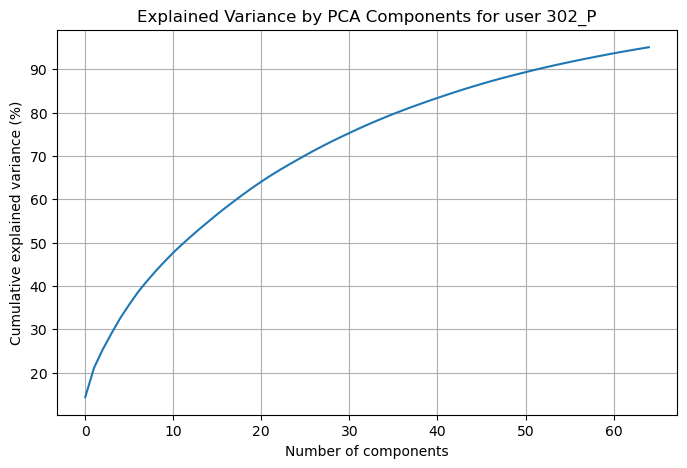

✅ Saved PCA features for user 302_P at ../../data/interim/text_features/302_P/pca_features.parquet
User: 301_P - Selected components: 48, Explained variance: 95.43%


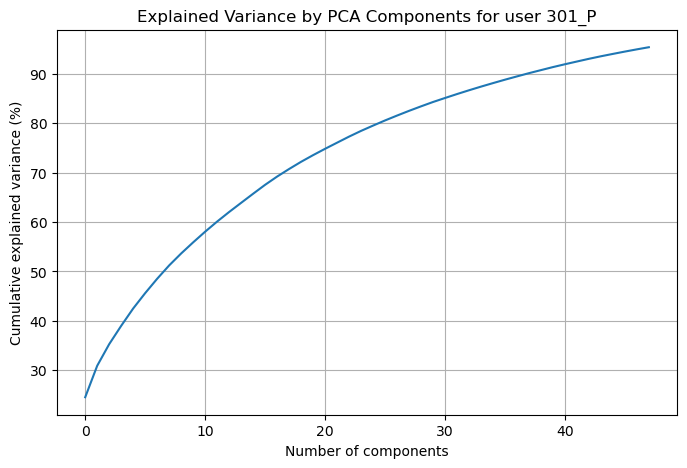

✅ Saved PCA features for user 301_P at ../../data/interim/text_features/301_P/pca_features.parquet


In [13]:
"""
This script processes RoBERTa text features for multiple users by:
1. Loading user-wise text feature files (.parquet) from a specified directory.
2. Applying PCA to reduce dimensionality while retaining 95% of variance.
3. Renaming reduced features to text_f1, text_f2, ..., and keeping time columns (if available).
4. Plotting explained variance for each user.
5. Saving the final PCA-transformed features (with time) back to disk for each user.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

SAVE_BASE_PATH = '../../data/interim/text_features'

def load_features_per_user(base_path):
    """Load RoBERTa features for each user separately, keeping time columns."""
    user_features = {}
    for user in os.listdir(base_path):
        user_dir = os.path.join(base_path, user)
        if os.path.isdir(user_dir):
            user_path = os.path.join(user_dir, 'text_features.parquet')
            if os.path.isfile(user_path):
                df = pd.read_parquet(user_path)
                feature_cols = [col for col in df.columns if col.startswith('roberta_')]
                
                # Collect both features and any time columns
                time_cols = [col for col in ['Start_Time', 'End_Time'] if col in df.columns]
                user_features[user] = {
                    'features': df[feature_cols],
                    'time_info': df[time_cols] if time_cols else None
                }
            else:
                print(f"⚠️ No features file for user {user}")
    return user_features

def plot_explained_variance(pca, user):
    plt.figure(figsize=(8,5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance (%)')
    plt.title(f'Explained Variance by PCA Components for user {user}')
    plt.grid(True)
    plt.show()

def save_pca_per_user(user_features):
    for user, data in user_features.items():
        features_np = data['features'].values
        time_info = data['time_info']
        
        pca = PCA(n_components=0.95)  # 95% variance
        pca_result = pca.fit_transform(features_np)
        
        print(f"User: {user} - Selected components: {pca.n_components_}, Explained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")
        
        # Plotting
        plot_explained_variance(pca, user)
        
        # Rename PCA features as text_f1, text_f2, ...
        pca_df = pd.DataFrame(
            pca_result,
            columns=[f'text_f{i+1}' for i in range(pca_result.shape[1])]
        )
        
        # Concatenate with time info if available
        if time_info is not None:
            pca_df = pd.concat([pca_df, time_info.reset_index(drop=True)], axis=1)
        
        # Save the final result
        save_path = os.path.join(SAVE_BASE_PATH, user, 'pca_features.parquet')
        pca_df.to_parquet(save_path, index=False)
        print(f"✅ Saved PCA features for user {user} at {save_path}")

def main():
    print("📥 Loading all RoBERTa features per user...")
    user_features = load_features_per_user(SAVE_BASE_PATH)
    
    print("🎯 Applying PCA and saving features...")
    save_pca_per_user(user_features)

if __name__ == "__main__":
    main()


In [14]:
"""
This script loads and displays the PCA-transformed features (including time info if available)
for each user individually from disk, without combining into a single table.
"""

import os
import pandas as pd

SAVE_BASE_PATH = '../../data/interim/text_features'

def load_and_display_pca_per_user(base_path):
    for user in os.listdir(base_path):
        user_dir = os.path.join(base_path, user)
        if os.path.isdir(user_dir):
            pca_path = os.path.join(user_dir, 'pca_features.parquet')
            if os.path.isfile(pca_path):
                print(f"\n📄 User: {user} - PCA Feature Preview")
                df = pd.read_parquet(pca_path)
                print(df.head(5)) 
            else:
                print(f"⚠️ No PCA file found for user {user}")

def main():
    print("📊 Loading PCA-transformed features per user...")
    load_and_display_pca_per_user(SAVE_BASE_PATH)

if __name__ == "__main__":
    main()


📊 Loading PCA-transformed features per user...

📄 User: 302_P - PCA Feature Preview
    text_f1   text_f2   text_f3   text_f4   text_f5   text_f6   text_f7  \
0 -0.000233 -0.068154  0.115495  0.007713 -0.058925 -0.089828  0.023439   
1  0.072134  0.112424  0.072628  0.007880 -0.176542 -0.035985 -0.021087   
2  0.058569  0.036078 -0.024689  0.027056 -0.264887  0.040238 -0.027480   
3  0.003342  0.048205 -0.010832 -0.067501 -0.259195  0.042159 -0.031395   
4  0.002634  0.106570 -0.018318 -0.006074 -0.105894 -0.033868 -0.041763   

    text_f8   text_f9  text_f10  ...  text_f58  text_f59  text_f60  text_f61  \
0 -0.091668 -0.115124  0.000469  ...  0.032283  0.013433  0.011236  0.040958   
1 -0.042957 -0.006753 -0.052942  ...  0.008638  0.019861  0.045775 -0.004708   
2  0.017302  0.027159  0.207756  ... -0.027745  0.062200  0.091477 -0.047911   
3 -0.018721 -0.057026  0.062713  ... -0.007742 -0.086280 -0.012191  0.011219   
4 -0.080666  0.022367  0.077644  ...  0.036419 -0.040610 -0.03539